In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree, faces, TreeStyle, COLOR_SCHEMES, CircleFace,TextFace, NodeStyle
from pylab import *

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
dfs = pd.read_excel('data4Joon.xlsx', sheet_name=None)

In [3]:
sheet_names = list(dfs.keys())
sheet_labels = ['Isolate01_Rep01','Isolate01_Rep02','Isolate01_Rep03',
                'Isolate02_Rep01','Isolate02_Rep02',
                'Isolate03_Rep01','Isolate03_Rep02','Isolate03_Rep03',
                'Isolate04_Rep01','Isolate04_Rep02','Isolate04_Rep03',
                'Isolate05_Rep01','Isolate05_Rep02','Isolate05_Rep03',
                'Isolate06_Rep01','Isolate06_Rep02','Isolate06_Rep03']

In [ ]:
cmap = cm.get_cmap('tab20', 17)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    colors.append(matplotlib.colors.rgb2hex(rgb))

In [4]:
cmap = cm.get_cmap('tab20c', 15)
cmap_ee = cm.get_cmap('tab20')
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    if (i==3):
        colors += [matplotlib.colors.rgb2hex(cmap_ee(i)[:3]) for i in [10,11]]
    colors.append(matplotlib.colors.rgb2hex(rgb))


In [ ]:
colors = []
# 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds'
cmap = cm.get_cmap('Purples', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(3)]
cmap = cm.get_cmap('Blues', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(2)]
cmap = cm.get_cmap('Greens', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(3)]
cmap = cm.get_cmap('Oranges', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(3)]
cmap = cm.get_cmap('Reds', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(3)]
cmap = cm.get_cmap('Greys', 5)
colors += [matplotlib.colors.rgb2hex(cmap(3-i)[:3]) for i in range(3)]

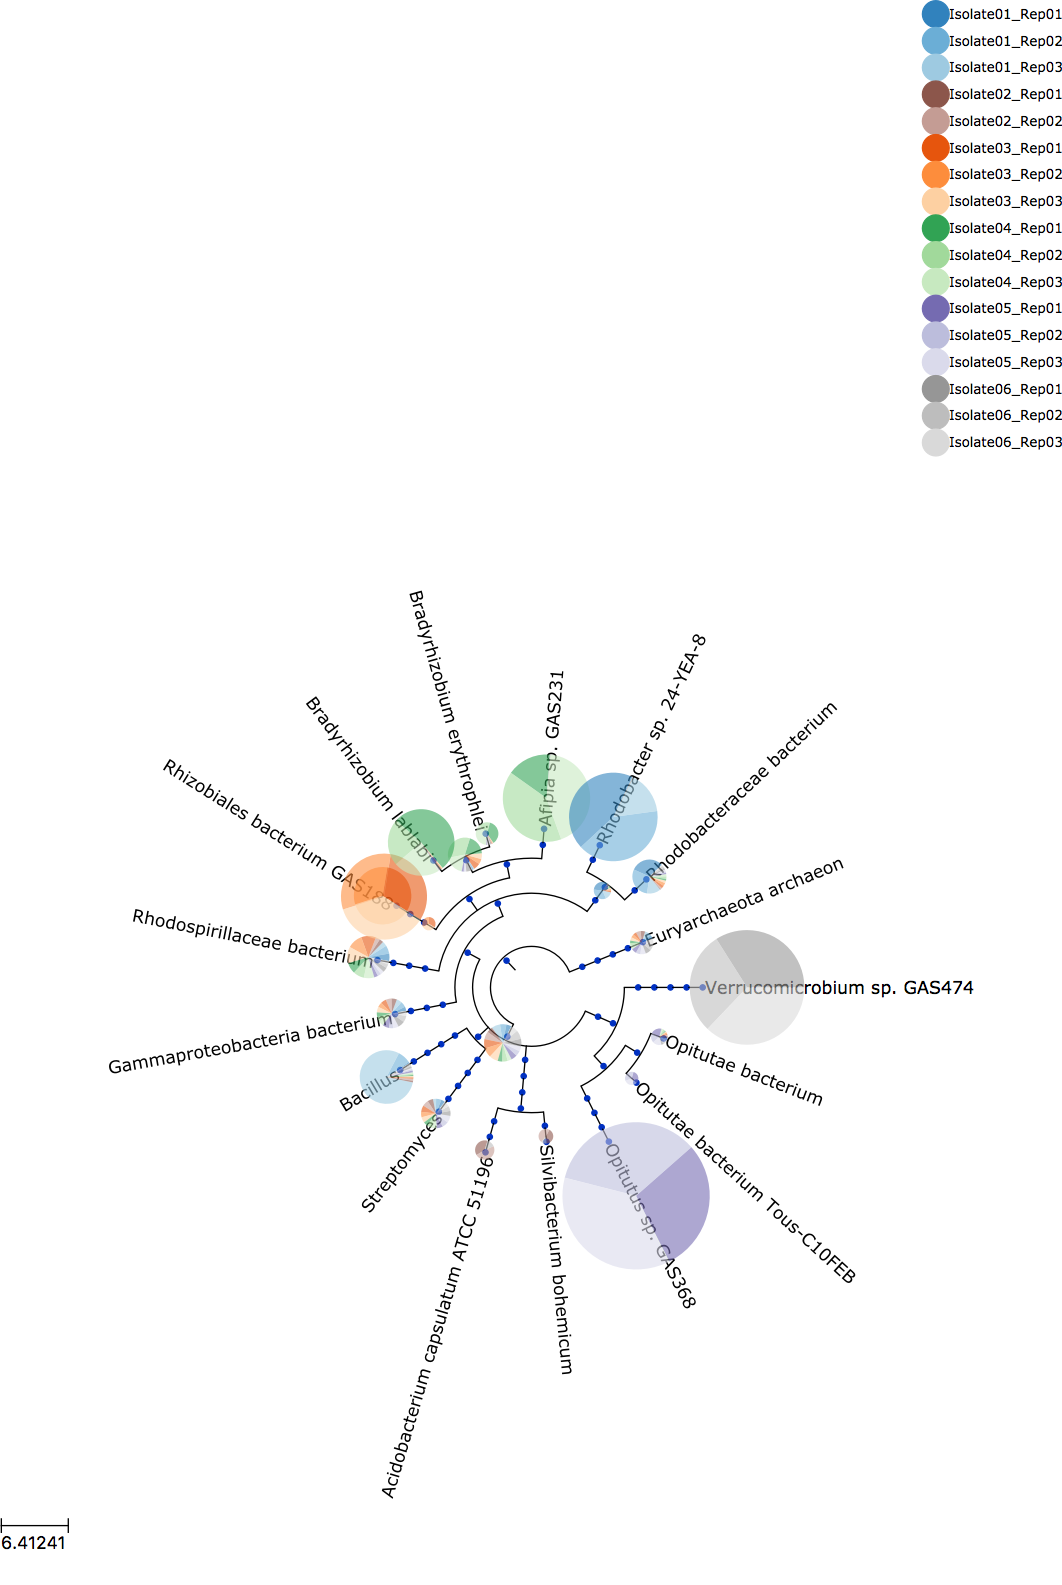

In [6]:
# cordination of the tree branches could be varing when you run the script.

# sheet_names = ['GAS474_2690315640_01',
#  'GAS474_2690315640_02',
#  'GAS474_2690315640_03']

ntops=5

def collect_scores(dfs, sheet_names, node):
    scores = [0]*len(sheet_names)
    for i, name in enumerate(sheet_names):
        df = dfs[name]
        temp = df[df.lineage.str.endswith(node)]
        if (temp.shape[0] == 1):
            scores[i] = temp.sample1.tolist()[0]
        elif temp.shape[0] > 1:
            print(name, node, "same species more than once?")
    return scores
    
table = []
nodes = []
for s in sheet_names:
    branches = dfs[s].iloc[0:ntops].lineage.str.split(';').tolist()
    for b in branches:
        table += [(b[i],b[i+1],1.0) for i in range(len(b)-1)]
        if b[-1] not in nodes: nodes.append(b[-1])
table = set(table)

### collect scores
scores = {}
max_sum = 0
min_sum = 1e10
for node in nodes:
    s = collect_scores(dfs, sheet_names, node)
    _sum = np.sum(s)
    if max_sum < _sum: max_sum = _sum
    if min_sum > _sum: min_sum = _sum
    scores[node] = collect_scores(dfs, sheet_names, node)

def layout(node):
    if node.name in scores:
        score = np.array(scores[node.name])
        _sum = np.sum(score)
        size = 10 + 100 * (np.sum(score) - min_sum)/(max_sum - min_sum)
        F= faces.PieChartFace(100*score/_sum,
                              colors=colors,
                              width=size, height=size)
        F.border.width = None
        F.opacity = 0.6
        #faces.add_face_to_node(F, node, 0, position="float-behind")
        faces.add_face_to_node(F, node, 1, position="float")
    if node.is_leaf():
        faces.add_face_to_node(TextFace(node.name.split("__")[1].split("(")[0], fsize=13), node, column=1)

def get_tree():
    t = Tree.from_parent_child_table(table)
    
    thick_hz_line = NodeStyle()
    thick_hz_line["hz_line_width"] = 4
    t.children[0].set_style(thick_hz_line)
    t.children[1].set_style(thick_hz_line)
    
    thick_vt_line = NodeStyle()
    thick_vt_line["vt_line_width"] = 1
    thick_vt_line["hz_line_width"] = 1
    thick_vt_line["size"] = 4
    
    t.set_style(thick_vt_line)
    
    for n in t.traverse():
        n.set_style(thick_vt_line)
    
    ts = TreeStyle()
    for i, s in enumerate(sheet_names):
        ts.legend.add_face(CircleFace(10, colors[i]), column=0)
        ts.legend.add_face(TextFace(sheet_labels[i]), column=1)
    ts.layout_fn = layout
    ts.mode = "c"
    ts.show_leaf_name = False
    ts.min_leaf_separation = 14
    
    return t, ts

t, ts = get_tree()
# t.show(tree_style=ts)

# t.render("float_piechart_all_5.pdf", tree_style=ts, w=800, units="mm") # render to the file
t.render("%%inline", tree_style=ts, w=300, units="mm") # render to the notebook